In [1]:
import os
import sys
sys.path.append("../")
sys.path.append("../REDPAN_tools")
import logging
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from copy import deepcopy
from glob import glob
from obspy import read
from model_loader import redpan_picker
from REDPAN_picker import extract_picks
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_devices = tf.config.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
logging.basicConfig(
    level=logging.INFO, format="%(levelname)s : %(asctime)s : %(message)s"
)

2023-05-25 20:59:49.921732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the encapsulated RED-PAN API

In [2]:
### Model selection. 
# Please make sure the model (absolute/relative) path is correct.
# assign ${mdl_hdr} with "REDPAN_30s" or "REDPAN_60s"
# REDPAN_30s: model of 30-second-long receptive field
# REDPAN_60s: model of 60-second-long receptive field
mdl_hdr = "REDPAN_60s" # assign with "REDPAN_30s" or "REDPAN_60s"
model_path = f"../pretrained_model/{mdl_hdr}"

### prediction parameters and information
# delta, we use broadband seismometers with sample rate of 100 Hz
dt = 0.01
# sliding window length for making predictions
pred_interval_sec = 15
# set `bandpass=None` to disable waveform bandpass filtering
bandpass = [5, 45]
# Post-processing configurations. 
# This only preserve the thresholded values. Others are filled with zeros.
postprocess_config = {
    "mask_trigger": [0.3, 0.3], # trg_on and trg_off threshold
    "mask_len_thre": 0.5, # minimum length of mask in seconds
    "mask_err_win": 0.5, # potential window in seconds for mask error
    "detection_threshold": 0.5, # detection threshold for mask
    "P_threshold": 0.3, # detection threshold for P
    "S_threshold": 0.3 # detection threshold for S
}

### load the encapsulated RED-PAN API
# set postprocess_config=None to disable postprocessing
picker, pred_npts = redpan_picker(
    model_path=model_path, 
    pred_interval_sec=pred_interval_sec,
    dt=dt,
    postprocess_config=postprocess_config
)

2023-05-25 20:59:52.683963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


Loaded PhasePicker: REDPAN_60s
Model path: /home/rick/Desktop/RED-PAN/pretrained_model/REDPAN_60s


## The picker can adapt waveforms in any length

### Make predictions on the waveform shorter than model receptive field

1 Trace(s) in Stream:
BW.RJOB..redpan_P | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:21:02.990000Z | 100.0 Hz, 6000 samples
1 Trace(s) in Stream:
BW.RJOB..redpan_S | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:21:02.990000Z | 100.0 Hz, 6000 samples
1 Trace(s) in Stream:
BW.RJOB..redpan_mask | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:21:02.990000Z | 100.0 Hz, 6000 samples


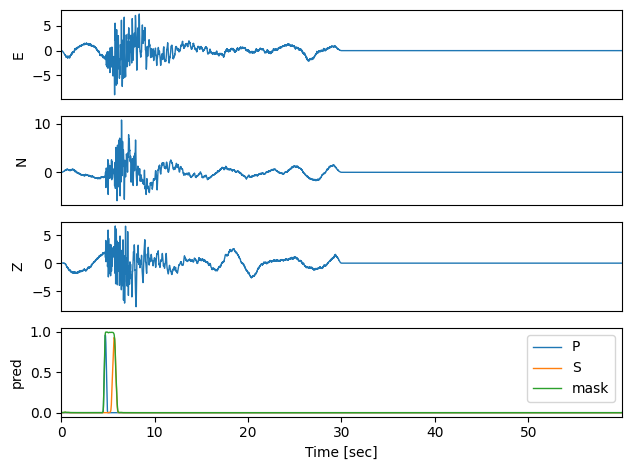

In [4]:
# read the default waveform from obspy, which is 30-second-long
wf1 = read(); wf1.sort()
# the redpan_picker function will complement the waveform to fulfill the length that the model needs
P_stream, S_stream, M_stream = picker.annotate_stream(wf1)
print(P_stream)
print(S_stream)
print(M_stream)
# plot the predictions
fig, ax = plt.subplots(4, 1)
x = np.arange(pred_npts)*0.01
x_data = [wf1[0].data, wf1[1].data, wf1[2].data]
ylabels = ['E', 'N', 'Z']
pred_label = ['P', 'S', 'mask']
pred_data = [P_stream[0].data, S_stream[0].data, M_stream[0].data]
for i in range(3):
    ax[i].plot(x, x_data[i], linewidth=1)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_xticks([])
    ax[3].plot(x, pred_data[i], linewidth=1, label=pred_label[i])
    
ax[3].set_xlim(x.min(), x.max())
ax[3].legend()
ax[3].set_ylabel('pred')
ax[3].set_xlabel('Time [sec]')
plt.tight_layout()
plt.show()

### Make predictions on the waveform shorter than model receptive field

In [ ]:
# read the default waveform from obspy, which is 30-second-long
wf2 = read('../temp_03_continuous_predict/Ridgecrest_WFs/2019.185.17/*CLC*')
wf2.sort()
# the redpan_picker function will complement the waveform to fulfill the length that the model needs
P_stream, S_stream, M_stream = picker.annotate_stream(wf2)
print(P_stream)
print(S_stream)
print(M_stream)

# plot the predictions
fig, ax = plt.subplots(4, 1)
x = np.arange(len(P_stream[0].data))*0.01
x_data = [wf2[0].data, wf2[1].data, wf2[2].data]
ylabels = ['E', 'N', 'Z']
pred_label = ['P', 'S', 'mask']
pred_data = [P_stream[0].data, S_stream[0].data, M_stream[0].data]
for i in range(3):
    ax[i].plot(x, x_data[i], linewidth=1)
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_xlim(x.min(), x.max())
    ax[i].set_xticks([])
    ax[3].plot(x, pred_data[i], linewidth=1, label=pred_label[i])
    
ax[3].set_xlim(x.min(), x.max())
ax[3].legend()
ax[3].set_ylabel('pred')
ax[3].set_xlabel('Time [sec]')
plt.tight_layout()
plt.show()

# extract pick and convert to pandas.DataFrame object
pick_df = extract_picks(
    wf2, 
    P_stream, 
    S_stream, 
    M_stream, 
    dt=0.01,
    p_amp_estimate_sec=1, 
    s_amp_estimate_sec=3,
    args={"detection_threshold":0.5, "P_threshold":0.3, "S_threshold":0.3}
)
print(pick_df)

3/3 [==============================] - 0s 34ms/step
